In [42]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import cv2
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Dataset paths
data_dir = "data"  # Adjust to your dataset path
batch_size = 32
num_epochs = 25
image_size = 200  # Your images are 200x200

Using device: cuda


In [44]:
# Define transforms (correct RGB normalization)
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Fixed for RGB
])

val_test_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [45]:
# Load dataset
full_dataset = datasets.ImageFolder(os.path.join(data_dir, "asl_alphabet_train/asl_alphabet_train"), transform=train_transforms)

# Get class names
class_names = full_dataset.classes
print(f"Class names: {class_names}")

Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [46]:
# Split into train/val/test (80/10/10)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Override transforms for val/test
val_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

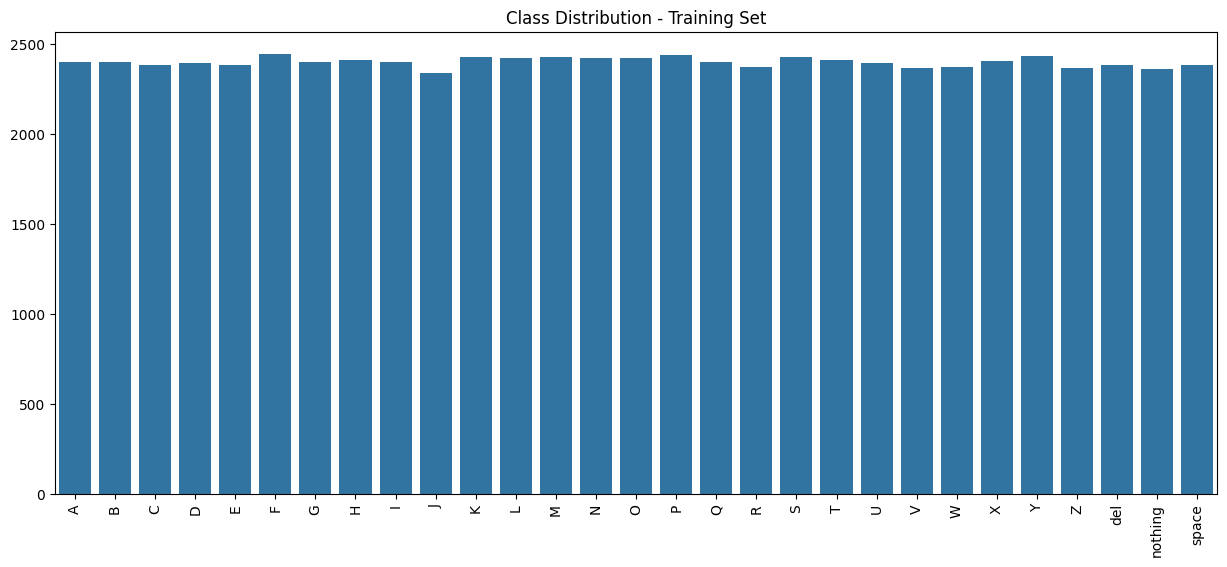

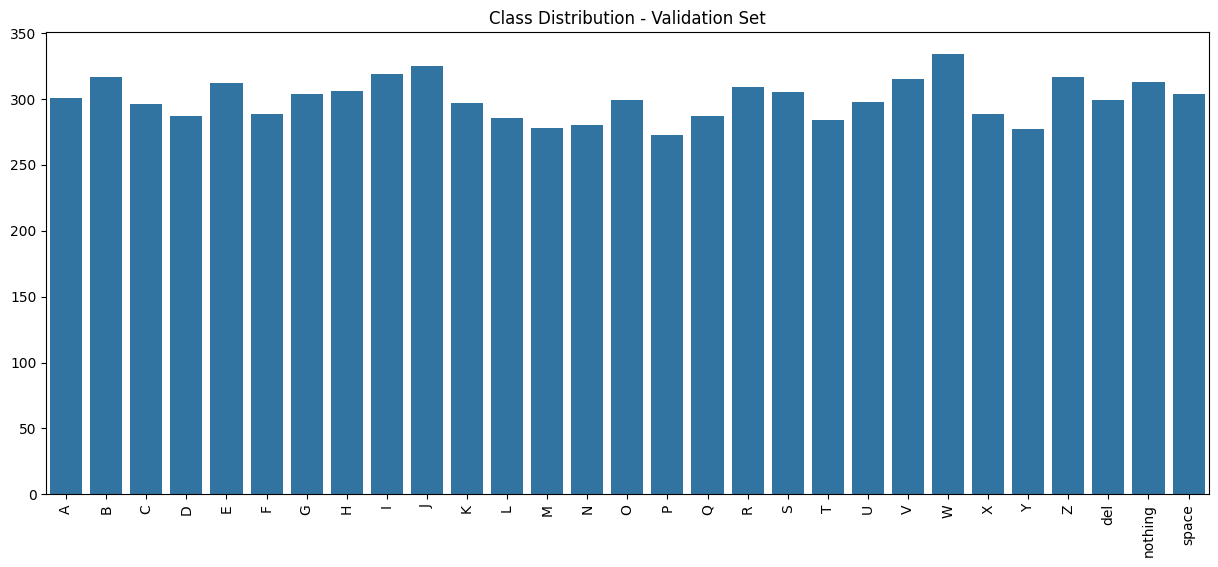

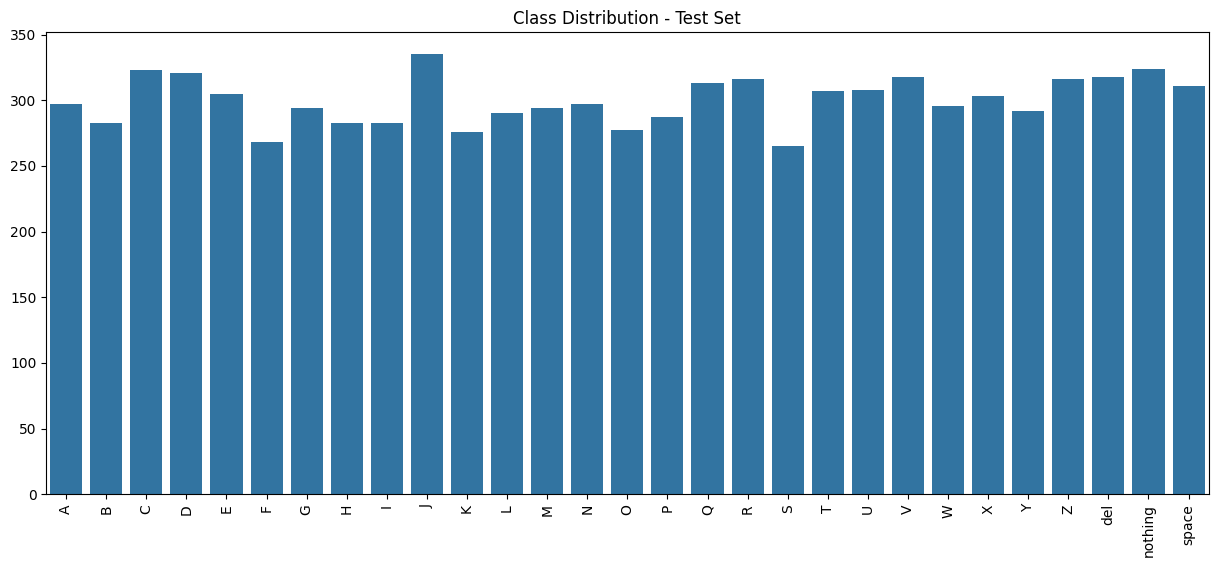

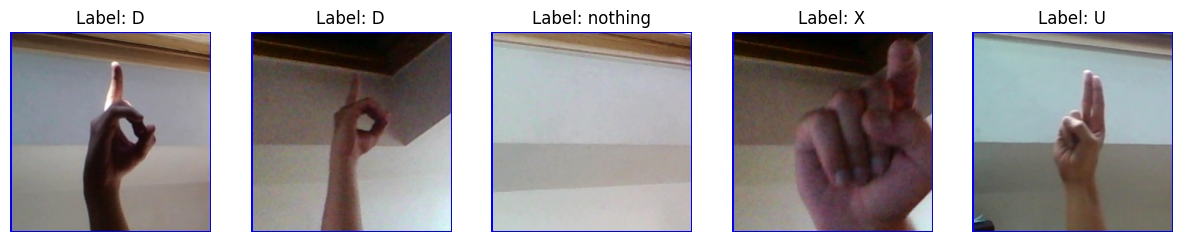

In [47]:
# ====================== EDA (Exploratory Data Analysis) ======================
def plot_class_distribution(dataset, title):
    # Get class distribution
    class_counts = np.zeros(len(class_names))
    for _, label in dataset:
        class_counts[label] += 1

    # Plot
    plt.figure(figsize=(15, 6))
    sns.barplot(x=class_names, y=class_counts)
    plt.title(f"Class Distribution - {title}")
    plt.xticks(rotation=90)
    plt.show()

# Plot distributions
plot_class_distribution(train_dataset, "Training Set")
plot_class_distribution(val_dataset, "Validation Set")
plot_class_distribution(test_dataset, "Test Set")

# Plot sample images
def plot_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img, label = dataset[i]
        img = img.permute(1, 2, 0).numpy()  # Convert CxHxW to HxWxC
        img = (img * 0.5 + 0.5)  # Undo normalization
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {class_names[label]}")
        axes[i].axis("off")
    plt.show()

plot_sample_images(train_dataset)

In [48]:
# ====================== Model Definition ======================
class ASLModel(nn.Module):
    def __init__(self, num_classes=29):
        super(ASLModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 25 * 25, 512)  # After 3 pools: 200 → 100 → 50 → 25
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = ASLModel(num_classes=29).to(device)


Epoch 1/25


Training:   0%|          | 0/2175 [00:00<?, ?it/s]

Train Loss: 1.2432 | Train Acc: 64.51%
Val Loss: 0.4967 | Val Acc: 82.62%

Epoch 2/25


Train Loss: 0.3843 | Train Acc: 87.03%
Val Loss: 0.4216 | Val Acc: 86.07%

Epoch 3/25


Train Loss: 0.3019 | Train Acc: 90.28%
Val Loss: 0.3914 | Val Acc: 87.53%

Epoch 4/25


Train Loss: 0.8099 | Train Acc: 80.47%
Val Loss: 0.3746 | Val Acc: 89.30%

Epoch 5/25


Train Loss: 0.2201 | Train Acc: 93.11%
Val Loss: 0.3544 | Val Acc: 89.76%

Epoch 6/25


Train Loss: 0.2225 | Train Acc: 93.47%
Val Loss: 0.2977 | Val Acc: 92.98%

Epoch 7/25


Train Loss: 0.1955 | Train Acc: 94.47%
Val Loss: 0.4348 | Val Acc: 91.36%

Epoch 8/25


Train Loss: 0.0419 | Train Acc: 98.63%
Val Loss: 0.1668 | Val Acc: 96.24%

Epoch 9/25


Train Loss: 0.0207 | Train Acc: 99.29%
Val Loss: 0.1791 | Val Acc: 96.08%

Epoch 10/25


Train Loss: 0.0138 | Train Acc: 99.53%
Val Loss: 0.1731 | Val Acc: 96.59%

Epoch 11/25


Train Loss: 0.0101 | Train Acc: 99.67%
Val Loss: 0.1796 | Val Acc: 96.69%
Early stopping triggered.


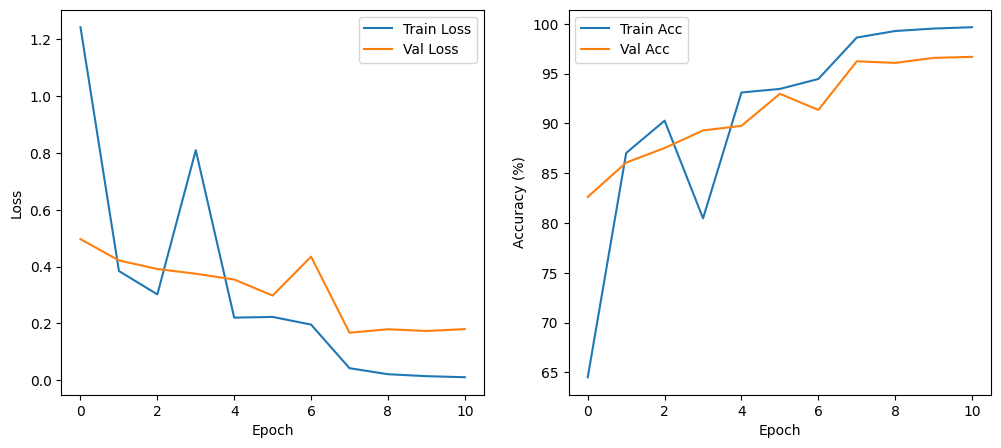

In [49]:
# ====================== Training Loop (with tqdm) ======================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)  # Decay LR every 7 epochs

best_val_loss = float('inf')
patience = 3
patience_counter = 0

# Store metrics for plotting
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    train_bar = tqdm(train_loader, desc="Training", leave=False)
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        train_bar.set_postfix(loss=loss.item(), acc=100.*correct_train/total_train)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    val_bar = tqdm(val_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

            val_bar.set_postfix(loss=loss.item(), acc=100.*correct_val/total_val)

    # Calculate epoch metrics
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_acc = 100 * correct_train / total_train
    val_acc = 100 * correct_val / total_val

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # Learning rate scheduling
    scheduler.step()

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_asl_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Plot training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

Testing: 100%|██████████| 272/272 [00:19<00:00, 14.03it/s]



Classification Report:
              precision    recall  f1-score   support

           A       0.95      0.94      0.95       297
           B       0.91      0.93      0.92       283
           C       0.95      0.96      0.96       323
           D       0.96      0.96      0.96       321
           E       0.94      0.94      0.94       305
           F       0.96      0.95      0.96       268
           G       0.97      0.96      0.96       294
           H       0.98      0.98      0.98       283
           I       0.98      0.98      0.98       283
           J       0.97      0.98      0.98       335
           K       0.97      0.97      0.97       276
           L       0.98      0.98      0.98       290
           M       0.98      0.96      0.97       294
           N       0.98      0.99      0.98       297
           O       0.96      0.97      0.97       277
           P       1.00      1.00      1.00       287
           Q       1.00      1.00      1.00       313
   

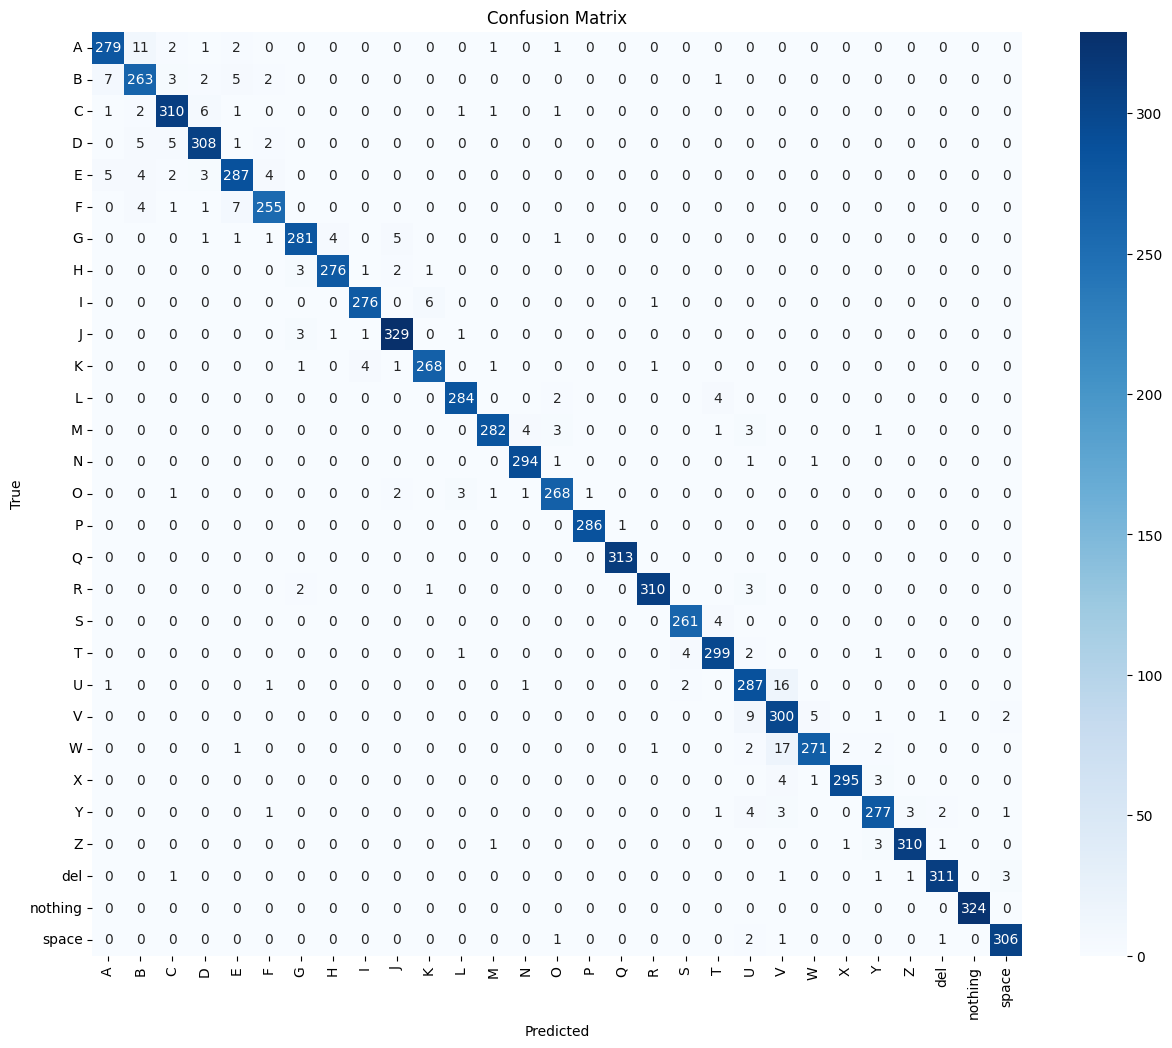

In [ ]:
# ====================== Testing (with tqdm) ======================
model.load_state_dict(torch.load("./models/best_asl_model.pth"))
model.eval()

all_preds = []
all_labels = []

test_bar = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for inputs, labels in test_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
plt.figure(figsize=(15, 12))
sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt="d", 
            xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [52]:
# ====================== Real-Time Prediction ======================
def preprocess_frame(frame):
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (image_size, image_size))
    frame = transforms.ToTensor()(frame).unsqueeze(0).to(device)
    frame = transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])(frame)
    return frame

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Hand detection ROI
    h, w = frame.shape[:2]
    x1, y1, x2, y2 = int(w * 0.4), int(h * 0.3), int(w * 0.8), int(h * 0.7)
    cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
    hand_roi = frame[y1:y2, x1:x2]

    if hand_roi.size != 0:
        img_tensor = preprocess_frame(hand_roi)
        with torch.no_grad():
            outputs = model(img_tensor)
            _, pred = torch.max(outputs, 1)
            label = class_names[pred.item()]

        cv2.putText(frame, f"Pred: {label}", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow("ASL Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()